# Advanced Machine Learning - programming assignment 3

*Due: Friday January 14*

*Grading: 10 points total*

**Please fill in:**
* Amy Oey (7082770)
* Sunny Hsieh (6534856)

### Further instructions:
* Make sure your code is properly commented.
* Submit your code in Blackboard using one of your accounts; we will put the grade in Blackboard for the other team member as well.
* **Make sure to name the submitted file according to your and your collaborators last name.** (`submitter_collaborator.ipynb`)

## Structural causal models
In this programming assignment, we will look at data from a structural causal model, and see how we can estimate the causal effect of $X$ on $Y$ from these data. The model consists of three variables:

* $X$ is the treatment: the dosage of a drug taken by a patient;
* $Y$ is the outcome: a numerical score reflecting how well the patient recovered;
* $Z$ is an additional variable that summarizes relevant genetic information about a patient.

$Y$ and $Z$ are continuous (real-valued), while $X$ is discrete.

The following code generates and plots observational data from this model.

In [13]:
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt

# The following three functions implement the structural equations of an SCM with three
# endogenous variables X, Y, and Z. Each endogenous variable in this SCM has one exogenous
# parent (unnamed) whose value is sampled by the corresponding function. Each of these
# functions operates on numpy arrays of length num_samples, where num_samples is the
# number of data points.
def f_Z(num_samples):
    return 4 * np.random.random(size=num_samples) + 4 * np.random.random(size=num_samples)
def f_X(z, num_samples):
    x_cont = z + np.random.normal(loc=0.0, scale=1.0, size=num_samples)
    return np.clip(2 * np.around(0.5 * (x_cont)), 0, 10).astype(dtype=int)
def f_Y(z, x, num_samples):
    return 2*z - x + np.random.normal(loc=0.0, scale=0.4, size=num_samples)

# Generate data from the observational distribution.
def generate_observational_data(num_samples):
    z = f_Z(num_samples)
    x = f_X(z, num_samples)
    y = f_Y(z, x, num_samples)
    return (x, y, z)

num_samples_obs = 1000

x, y, z = generate_observational_data(num_samples_obs)

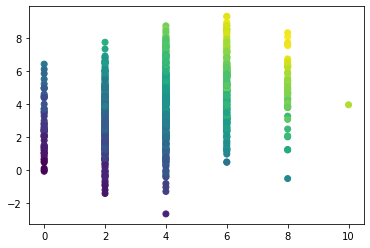

In [14]:
plt.scatter(x, y, c=z)
plt.show()

**Task (1 point):** Use any supervised learning method of your choice to fit a function from $X$ to $Y$ to these data. (So $X$ is the only feature; $Z$ is not used. Note that you are *not* asked to validate or test your fit here.) Make a new plot that displays both the data points and your fitted function, for $x$ in the range $[0,10]$.


To plot a regression curve, first use a function like `np.linspace` to create an array of neatly ordered x-values. Then have your trained machine learning model predict the y-values corresponding to those x-values.

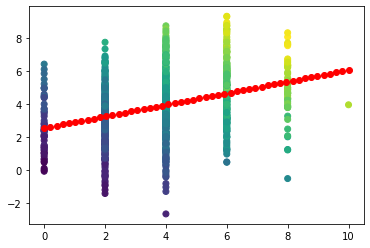

In [15]:
#ANSWER

from sklearn.linear_model import LinearRegression
model_task1 = LinearRegression()
model_task1.fit(x.reshape(-1,1), y)

x_values = np.linspace(0,10)
y_values = model_task1.predict(x_values.reshape(-1,1))

plt.scatter(x,y,c=z)
plt.scatter(x_values, y_values, color='red')
plt.show()

Look at the code of `f_X`, `f_Y`, `f_Z`, and `generate_observational_data` to answer the following questions.

**Question (1 point):** For each endogenous variable, what other endogenous variables are the direct causes? For each such relation between two variables, explain what the presence of this relation means in the real world, where the three variables represent treatment, outcome, and genetic information.

**Answer**
If we look at f_X f_Y and f_Z we see that Z has a direct cause on X, Z itself has no endogenous variables that it depends on, and X and Z are direct causes for Y. 
Abstractly this corresponds to: Z --> X , Z --> Y and X --> Y
The genetic information of a person has an influence on the treatment dosage, but it will also have an effect on the outcome of the treatment next to the treatment itself.

## Intervening on the system

Now we will consider what happens if we intervene on the system by prescribing certain dosages of the drug.

**Task (1 point):** Complete the following function, which is analogous to the function `generate_observational_data`, except now instead of observational data, each data point $(x_i, y_i, z_i)$ should be generated from the interventional distribution with $do(X=x_i)$. The values $x_i$ are specified by the array `x`, which is the first argument of this function.

In [16]:
#ANSWER:

def generate_experimental_data(x, num_samples):
    z = f_Z(num_samples)
    y = f_Y(z, x, num_samples)

    return (x, y, z)

We will look at interventional data where for each data point, the dosage is chosen uniformly at random from the set $\{0,2,4,8\}$, independently for each individual.

In [17]:
num_samples_exp = 200

# Set the values of x according to the distribution specified above, then generate the whole data
# under the intervention do(X=x).
x_exp = np.random.choice(np.array([0, 2, 4, 8], dtype=int), size=num_samples_exp)
(x_exp, y_exp, z_exp) = generate_experimental_data(x_exp, num_samples_exp)

**Task (0.5 points):** Plot these experimental data in the same way as before, again including the curve you fit earlier to the observational data.

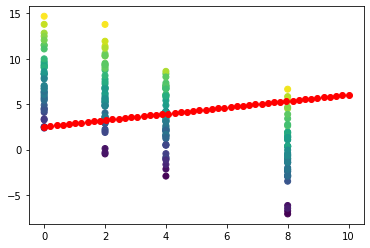

In [18]:
# Your code here
#ANSWER:
plt.scatter(x_exp, y_exp, c=z_exp)
plt.scatter(x_values,y_values,c='red')
plt.show()

**Task (0.5 points):** Compute the RMSE (root mean squared error) when you use the regression curve you learned earlier to predict $Y$ in these new data. (To put it another way: we used the observational data as training data, and now we are using the experimental data as test data.)

In [19]:
def RMSE(model, x, y):
  n = len(y)
  se = 0

  for i in range(n):
    se += (y[i] - model.predict(x[i].reshape(-1,1)))**2
  mse = se / n
  rmse = np.sqrt(mse)

  print("RSME is:",rmse[0])


In [20]:
RMSE(model_task1, x_exp, y_exp)

RSME is: 4.907333905154097


You should see in your plot that the curve we learned from the observational data, does not seem to work well for predicting the outcome $Y$ in the interventional data. This is because the experimental distribution is different from the observational distribution.

**Question (1 point):** Look at the product decompositions of the original SCM and the SCM modified by the intervention on $X$. Which factors in the decompositions are the same between the observational and the experimental distribution? In order for your fitted curve to also give good predictions on the experimental data, what conditional distribution would we need to stay the same between the two distributions?

**Answer**
Because of the SCM and the intervention on X we can see from the new SCM that Z stays the same even though we did an intervention on X. Y will change due to the fact that X is a direct cause of Y. 
Apparently it is important to keep the conditional distribution between Z and X.

The remaining questions use some concepts that we will see in the lectures of week 6 (d-separation and inverse probability weighing).

**Question (1.5 points):** What (marginal or conditional) independence should hold in the experimental data, based on d-separation? Plot the data in a way that illustrates this independence, and explain what property of the plot illustrates the independence.

**Answer**
X and Z are independent without conditioning. (But if we condition on Y then X and Z are likely dependent given Y).
In the plot we see that there is no correlation between X and Z meaning that they are independent of each other. They do not have any effect on each other.

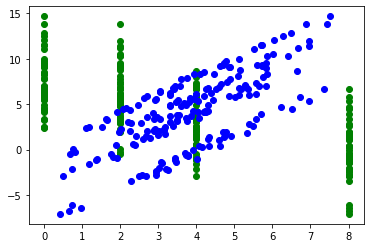

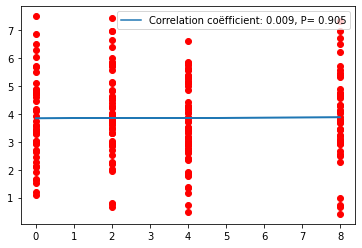

In [43]:
from scipy import stats
from numpy.polynomial.polynomial import polyfit
# Your code here
plt.scatter(x_exp, y_exp, c = 'green')
plt.scatter(z_exp, y_exp, c= 'blue')
plt.show()
plt.scatter(x_exp, z_exp, c = 'red')
b,m = polyfit(x_exp, z_exp, 1)
R,P = stats.pearsonr(x_exp, z_exp)
plt.plot(x_exp, b + m * x_exp, '-',label="Correlation coëfficient: {}, P= {}".format(round(R, 3),round(P, 3)))
plt.legend()
plt.show()

**Task (2 points):** Now, we will use the method of inverse probability weighing (section 3.6 in the book) for this task. Using *only the observational data*, fit a logistic regression to predict $X$ using $Z$ as a feature. From this logistic regression, extract estimates for $P(X=x_i|Z=z_i)$ for each data point $(x_i, y_i, z_i)$. (Consult the scikit-learn manual to learn how to do this.) Use these to compute an inverse probability weight for each data point in the observational data set.

Important note: the purpose of the logistic regression is *not* to predict the value of $X$, because we already know that value for each data point! But we do need the logistic regression to esimate the probability $P(X=x_i|Z=z_i)$.

In [44]:
# Create logistic regression object (using scikit-learn)
reg_logistic = linear_model.LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=500)

# Your code here

#ANSWER:

#step 1: fit the model
reg_logistic.fit(z.reshape(-1,1), x)
#step 2: get the prospensity score, for each data point (xi,yi,zi)
prospensity_score = reg_logistic.predict_proba(z.reshape(-1,1))
#step 3: get ipw
ipw = 1/prospensity_score
#step 4: get ipw for each data point x,y,z
ipw_vector = []
counter = 0
for item in x:
  index = int(item / 2) #x varies from 0,2,4,6,8 so map it to index 0,1,2,3,4
  ipw_vector.append(ipw[counter][index])
  counter += 1
#step 5: print result
print(len(ipw_vector))
print(ipw_vector)


1000
[3.371988409054293, 1.3748992942427871, 1.7891442271850013, 3.1939510606066532, 3.859837281820322, 2.257966174681613, 1.9170065148644038, 2.3494614677579513, 4.105551707293431, 3.0574101875076702, 15.739785851468241, 3.3108565807252743, 1.6110502419924342, 4.01672400366637, 1.5023228445064563, 5.059830044498949, 3.5567115054529177, 1.3726107540934922, 1.5237311928250235, 1.427190383866171, 1.385250917444735, 1.3902142736668908, 1.8148187393390005, 2.3109456436780165, 1.6980551395798422, 23.250818505000208, 1.8623928438525525, 5.803985401189103, 3.095927939850165, 1.4998626977240332, 1.54228213641929, 1.760074489112993, 1.488503850874743, 2.6391449018260533, 1.7088367253737147, 1.7704032697022243, 1.3800303606205029, 2.5854543241359043, 6.752708206284282, 10.027901807880324, 1.9995819840199633, 1.5441603335918423, 1.7868717342961018, 1.5165207625889323, 2.4650887350942674, 7.812424429938281, 3.2451259062904168, 1.5303710179449248, 1.3727122946345771, 2.63313627080288, 3.20066296221

**Task (1 point):** Now again predict $Y$ in terms of $X$ using only the observational data as training data, but this time weigh each data point with the inverse probability weight. (Machine learning libraries often provides a way to specify a weight for each data point when fitting a model to data; check the manual of the library you are using.) Plot your regression curve in the same plot as the experimental data, as before.

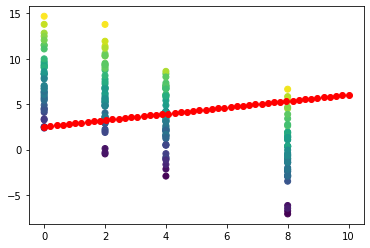

In [45]:
# Your code here

#ANSWER:

#build and fit model using weighs
weighed_lin_reg_model = LinearRegression()
weighed_lin_reg_model.fit(x.reshape(-1,1), y, ipw_vector)

#create predictions
weighed_x_values = np.linspace(0,10)
weighed_y_values = model_task1.predict(weighed_x_values.reshape(-1,1))

#plot the experimental data and fitted curve
plt.scatter(x_exp, y_exp, c=z_exp)
plt.scatter(weighed_x_values, weighed_y_values, color='red')
plt.show()

**Task (0.5 points):** To verify that these predictions of the causal effect of $X$ on $Y$ are more accurate, again compute the RMSE on the experimental data.

In [46]:
#ANSWER:

RMSE(weighed_lin_reg_model, x_exp, y_exp)

RSME is: 3.720683543771755


You are almost done! Before handing in, make sure that the code you hand in works, and that all plots are shown. **Submit just one file per team.** Name the submitted file according to your and your collaborator's last name (`submitter_collaborator.ipynb`).